In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [3]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [3]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [4]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya))

Detected 24936 / 49472 annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## TF gene transcript detection

What fraction of TF genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [8]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='tf')

# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

gene_df, _, _ = get_gtf_info(how='gene', subset='tf')

n_tf = len(gene_df.index)
n_det_tf = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated TF genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_tf, n_tf))

Calculating iso TPM values
Subsetting for TF genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on tf genes
Number of isos reported: 4630
Detected 1286 / 1419 annotated TF genes w/ at least 1 known transcript >= 1 TPM


## Protein coding gene transcript detection

What fraction of protein-coding genes do we detect with at least 1 known isoform >= 1 TPM in any library?

In [26]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
# no gene subset here so we can look at all other genes
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Number of isos reported: 77128


In [27]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [28]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')
df = df.merge(gene_df, how='left', left_on='annot_gene_id', right_on='gid')

In [30]:
temp = df[['gid', 'biotype_category']].drop_duplicates().groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,17052,19969,0.853924
0,lncRNA,4777,15006,0.318339
2,other,1908,7426,0.256935
1,miRNA,418,1881,0.222222
4,pseudogene,3107,14497,0.214320


## What fraction of protein coding gene transcripts do we detect?

Of the transcripts associated with protein coding genes GENCODE, how many do we detect >=1 TPM?

In [31]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [32]:
t_df, b_counts, b_cat_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [34]:
temp = df[['tid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'tid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
1,protein_coding,64084.0,151259,0.423671
0,lncRNA,7073.0,28478,0.248367
2,pseudogene,3639.0,17657,0.206094
3,miRNA,NaN,1881,NaN
4,other,NaN,7486,NaN


## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796
Found 31 total samples


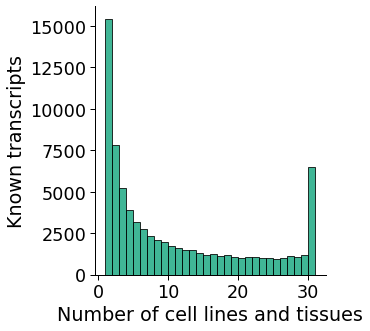

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = plot_biosamp_det(df,
                      how='iso',
                      min_tpm=1,
                      gene_subset='polya',
                      sample=None,
                      groupby='sample',
                      nov='Known',
                      opref='figures/human')

In [9]:
specific_thresh = 4
ubiq_thresh = 20

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

32327 / 74796 (43.2%) transcripts are expressed in <= 4 samples
16872 / 74796 (22.6%) transcripts are expressed in >= 20 samples


## Length of transcripts from polyA genes detected >= 1 TPM

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


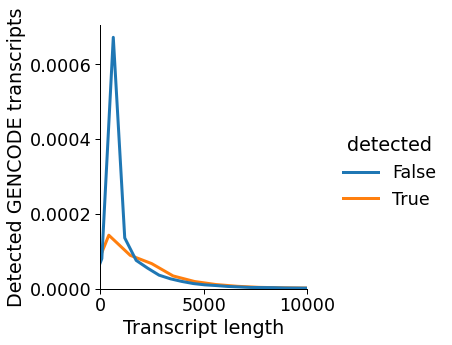

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/')

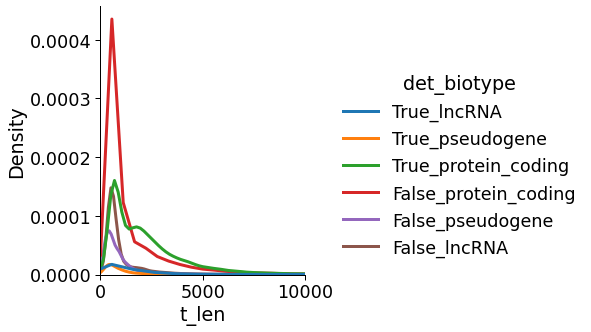

In [9]:
df['det_biotype'] = df.detected.astype('str')+'_'+df.biotype_category
ax = sns.displot(data=df, x='t_len', kind='kde',
                     linewidth=3, hue='det_biotype', common_norm=True)
ax.set(xlim=(0,10000))

What is the longest detected transcript with more than one exon?

In [7]:
t_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
t_df = t_df[['annot_transcript_id', 'n_exons']]

In [9]:
df = df.merge(t_df, how='left', on='annot_transcript_id')

In [10]:
n = df.loc[(df.detected == True)&(df.n_exons > 1), 't_len'].max()
print(n)

37852


In [11]:
df.loc[df.t_len == 37852]

,annot_transcript_id,tid,t_len,gid,biotype,biotype_category,detected,n_exons
70907,ENST00000458178.2,ENST00000458178.2,37852,ENSG00000224086.5,antisense,lncRNA,True,2.0


## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [41]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


## How many known polyA transcripts do we detect?

In [7]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [8]:
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [17]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya))

Detected 74796 / 197394 annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


  transcript_novelty  counts
0              Known   73961
1                NIC   18270
2                NNC    5796
Number of complete isoforms: 98027


<Figure size 288x432 with 0 Axes>

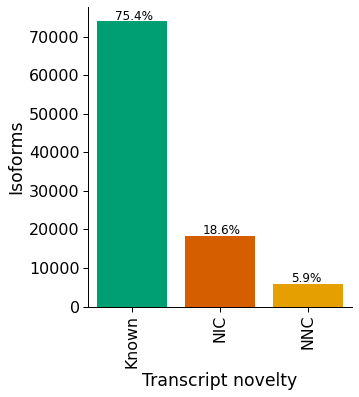

<Figure size 432x288 with 0 Axes>

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=['Known', 'NIC', 'NNC'])

## How many exons are in each complete, detected model, split by novelty?

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


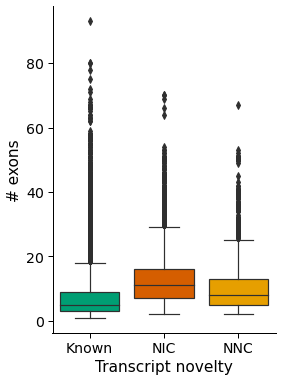

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_exons_per_iso(df,
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya',
                   opref='figures/human')

## How many isoforms per gene do we detect per sample? 

What is the average and range of complete isoforms per polyA gene that we detect per sample?

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


In [23]:
df.idxmax(axis=1)

annot_gene_id
ENSG00000000003.14              colon
ENSG00000000005.5        h9_panc_beta
ENSG00000000419.12    h9_neural_crest
ENSG00000000457.13    h9_neural_crest
ENSG00000000460.16     h9_panc_progen
                           ...       
ENSG00000285944.1               heart
ENSG00000285966.1               hffc6
ENSG00000285967.1               heart
ENSG00000285972.1               colon
ENSG00000285976.1             adipose
Length: 25044, dtype: object

In [30]:
temp = df.max(axis=1).to_frame()
temp.loc[temp[0] == 134]

,0
annot_gene_id,
ENSG00000049540.16,134


In [33]:
df.loc['ENSG00000049540.16'].idxmax()

'h9_chondro'

In [34]:
df.loc['ENSG00000049540.16', 'h9_chondro']

134

In [36]:
print('Average # isoforms / gene / sample: {}'.format(df.mean().mean()))

Average # isoforms / gene / sample: 1.4253880911531187


In [37]:
print('Max # isoforms / gene / sample: {}'.format(df.max().max()))

Max # isoforms / gene / sample: 134


Which samples have the highest average?

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


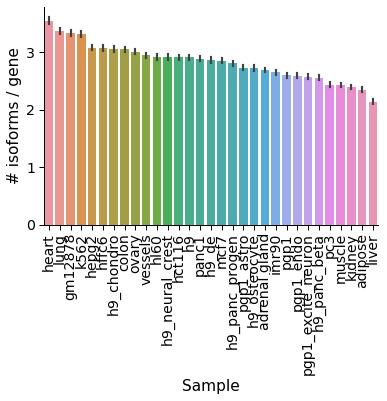

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='all', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

Calculating iso TPM values
Subsetting for tissue datasets
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 85582
Subsetting on polya genes
Number of isos reported: 84025
Found 10 total samples


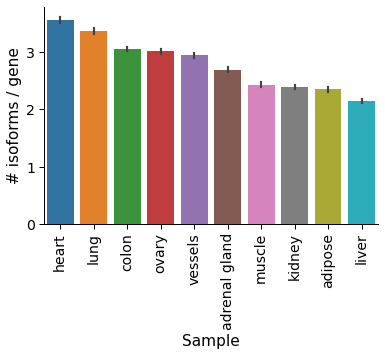

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='tissue', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

Number of libraries per sample

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples
Slope of correlation: 0.09325748752828794


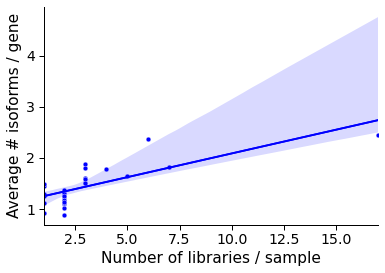

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_libs_v_avg_isos(df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Number of reads per sample

Found 31 total samples
Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples
Slope of correlation: 6.528030858818072e-08


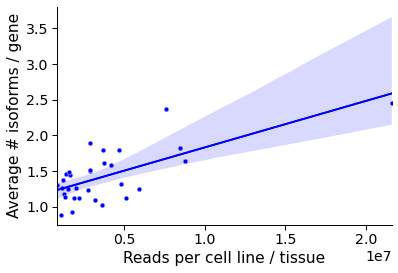

In [4]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_reads_v_avg_isos(df, filt_df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        groupby='sample',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

What fraction of polyA genes express >= 2 complete isoforms in more than half of their expressed samples?

In [5]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='polya',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # genes detected: 39285
# genes >= 1 tpm: 33946
Subsetting on polya genes
Number of genes reported: 32160
Found 31 total samples
Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


In [7]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} detected polyA genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n))

8879 / 32160 detected polyA genes express >=2 isoforms in at least half of their expressed samples


What fraction of TF genes express >= 2 complete isoforms in more than half of their expressed samples?


In [2]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='tf',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for TF genes
Enforcing minimum TPM
Total # genes detected: 39285
# genes >= 1 tpm: 33946
Subsetting on tf genes
Number of genes reported: 1356
Found 31 total samples
Calculating iso TPM values
Subsetting for TF genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on tf genes
Number of isos reported: 5479
Found 31 total samples


In [4]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} detected TF genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n))

570 / 1356 detected polyA genes express >=2 isoforms in at least half of their expressed samples


What fraction of polyA genes have >= 2 complete isoforms detected in the same sample?

In [7]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


In [10]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='polya')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated polyA genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

11170 / 49472 annotated polyA genes have >= 2 isoforms expressed in >= 1 sample


What fraction of TF genes have >= 2 complete isoforms detected in the same sample?

In [13]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for TF genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on tf genes
Number of isos reported: 5479
Found 31 total samples


In [15]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='tf')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated TF genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

735 / 1419 annotated TF genes have >= 2 isoforms expressed in >= 1 sample


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

TPM table debugging / rework

In [66]:
sample = 'all'
nov = ['Known', 'NIC', 'NNC']
min_tpm = 1
gene_subset = 'tf'
how = 'iso'
save = False

df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, ids = get_tpm_table(df,
                       )

In [67]:
if sample == 'cell_line' or sample == 'tissue':
    print('Subsetting for {} datasets'.format(sample))

dataset_cols = get_sample_datasets(sample)
df = rm_sirv_ercc(df)

In [68]:
# merge with information about the gene
gene_df, _, _ = get_gtf_info(how='gene')
gene_df = gene_df[['gid', 'biotype_category', 'tf']]
df = df.merge(gene_df, how='left', left_on='annot_gene_id', right_on='gid')

In [69]:
# get indices that we'll need to subset on 
if how == 'gene':
    id_col = 'annot_gene_id'
    nov_col = 'gene_novelty'
    nov = ['Known']
elif how == 'iso':
    id_col = 'annot_transcript_id'
    nov_col = 'transcript_novelty'
    
# filter on novelty 
if nov: 
    print('Subsetting for novelty categories {}'.format(nov))
    nov_inds = df.loc[df[nov_col].isin(nov), id_col].tolist()
else:
    nov_inds = df[id_col].tolist()
    
# filter on gene subset
if gene_subset:
    print('Subsetting for {} genes'.format(gene_subset))
    if gene_subset == 'polya':
        polya_cats = ['protein_coding', 'pseudogene', 'lncRNA']
        gene_inds = df.loc[df.biotype_category.isin(polya_cats), id_col].tolist()
    elif gene_subset == 'tf':
        gene_inds = df.loc[df.tf == True, id_col].tolist()
else:
    gene_inds = df[id_col].tolist()

# get intersection of both
subset_inds = list(set(nov_inds)&set(gene_inds))

# sum up counts across the same gene
if how == 'gene':
    df = df[dataset_cols+[id_col]]
    df = df.groupby(id_col).sum().reset_index()

# set index so that all values in df reflect
# counts per transcript or gene
df.set_index(id_col, inplace=True)

# compute TPM
tpm_cols = []
for d in dataset_cols:
    tpm_col = '{}_tpm'.format(d)
    total_col = '{}_total'.format(d)
    df[total_col] = df[d].sum()
    df[tpm_col] = (df[d]*1000000)/df[total_col]
    tpm_cols.append(tpm_col)
df = df[tpm_cols]

# reformat column names
df.columns = [c.rsplit('_', maxsplit=1)[0] for c in df.columns] 

# enforce tpm threshold
if min_tpm:
    print('Enforcing minimum TPM')
    print('Total # {}s detected: {}'.format(how, len(df.index)))
    df = df.loc[(df >= min_tpm).any(axis=1)]
    print('# {}s >= {} tpm: {}'.format(how, min_tpm, len(df.index)))

# subset if necessary
if gene_subset or nov:
    print('Applying gene type and novelty subset')
    df = df.loc[df.index.isin(subset_inds)]

print('Number of {}s reported: {}'.format(how, len(df.index)))

if save:
    fname = '{}_{}_tpm.tsv'.format(sample, how)
    df.to_csv(fname, sep='\t')

ids = df.index.tolist()    

Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 5201


In [65]:
df.head()

,gm12878_1_1,gm12878_1_2,gm12878_1_3,gm12878_1_4,gm12878_3_1,gm12878_2_1,gm12878_2_2,pgp1_1_1,pgp1_1_2,h9_1_1,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
annot_transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000469289.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000417324.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.52195,1.407444,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000461467.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.52195,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000442987.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000494149.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.52195,5.629775,1.064988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
